In [1]:
import numpy as np
from itertools import combinations as icmb
from typing import Tuple, Dict, Optional
from joblib import Parallel, delayed


class InfoCausality:
    """
    InfoCausality Class for Information-Theoretic Causality Analysis.
    Supports:
        - Shannon entropy
        - Mutual information
        - Conditional mutual information
        - Transfer entropy
        - SURD decomposition (Synergy, Unique, Redundancy)
    """

    def __init__(self, x: np.ndarray, nbins: int = 8):
        """
        Initialize InfoCausality Class from raw target-agents original-lagged data.

        Parameters
        ----------
        x : np.ndarray
            2D array where:
                - First column is the target variable (future)
                - Remaining columns are agent (predictor) variables.
        nbins : int
            Number of bins (states) per variable dimension for discretization.
        """
        self.p = self.create_pfm(x, nbins)
        self.Ntot = self.p.ndim
        self.Nvars = self.Ntot - 1
        self.Nt = self.p.shape[0]

    @staticmethod
    def create_pfm(x: np.ndarray, nbins: int) -> np.ndarray:
        x = x[~np.isnan(x).any(axis=1)]
        if not len(x): raise ValueError("All values are NaN in input array.")
        hist, _ = np.histogramdd(x, bins=nbins)
        hist = np.maximum(hist, 1e-14) #hist += 1e-14 
        hist /= hist.sum()
        return hist

    @staticmethod
    def mylog(x: np.ndarray) -> np.ndarray:
        valid = (x > 0) & np.isfinite(x)
        res = np.zeros_like(x)
        res[valid] = np.log2(x[valid])
        return res

    @staticmethod
    def entropy(p: np.ndarray) -> float:
        return -np.sum(p * InfoCausality.mylog(p))

    @staticmethod
    def entropy_nvars(p: np.ndarray, indices) -> float:
        excluded = tuple(set(range(p.ndim)) - set(indices))
        marginalized = p if not excluded else p.sum(axis=excluded)
        return InfoCausality.entropy(marginalized)

    @staticmethod
    def cond_entropy(p: np.ndarray, target_indices, conditioning_indices) -> float:
        joint = InfoCausality.entropy_nvars(p, tuple(set(target_indices) | set(conditioning_indices)))
        cond = InfoCausality.entropy_nvars(p, conditioning_indices)
        return joint - cond

    @staticmethod
    def mutual_info(p: np.ndarray, set1_indices, set2_indices) -> float:
        h1 = InfoCausality.entropy_nvars(p, set1_indices)
        cond_h = InfoCausality.cond_entropy(p, set1_indices, set2_indices)
        return h1 - cond_h

    @staticmethod
    def cond_mutual_info(p: np.ndarray, ind1, ind2, ind3) -> float:
        combined = tuple(set(ind2) | set(ind3))
        return InfoCausality.cond_entropy(p, ind1, ind3) - InfoCausality.cond_entropy(p, ind1, combined)

    def transfer_entropy(self) -> np.ndarray:
        num_vars = self.Nvars
        TE = np.zeros(num_vars)
        for i in range(1, num_vars + 1):
            present_indices = tuple(range(1, num_vars + 1))
            conditioning_indices = tuple(j for j in range(1, num_vars + 1) if j != i)
            cond_ent_past = InfoCausality.cond_entropy(self.p, (0,), conditioning_indices)
            cond_ent_past_input = InfoCausality.cond_entropy(self.p, (0,), present_indices)
            TE[i - 1] = cond_ent_past - cond_ent_past_input
        return TE

    # =====================================================
    # SURD decomposition (with parallel computation support)
    # =====================================================
    def surd(
        self,
        max_combs: Optional[int] = None,
        n_jobs: int = 1,
        backend: str = "loky",
    ) -> Dict:
        """
        Compute unified SURD decomposition, optionally with parallelization.

        Parameters
        ----------
        max_combs : int or None
            Maximum combination order for high-dimensional synergy computation.
            If None, standard SURD decomposition is used.
        n_jobs : int
            Number of parallel jobs (default 1 = no parallel).
        backend : str
            Joblib backend: 'loky', 'threading', or 'multiprocessing'.

        Returns
        -------
        dict
            {
                "synergistic": { "X1-X2": value, ... },
                "unique": { "X1": value, "X2": value, ... },
                "redundant": { "X1-X2": value, ... },
                "mutual_info": { "X1-X2": value, ... },
                "info_leak": float
            }
        """
        p = self.p
        H = self.entropy_nvars(p, (0,))
        Hc = self.cond_entropy(p, (0,), range(1, self.Ntot))
        info_leak = Hc / H

        inds = range(1, self.Ntot)
        Nt = self.Nt

        # ========== Helper for parallel computing ==========
        def compute_Is(j_tuple):
            """Compute Is[j] for given agent combination j."""
            if max_combs is None:
                noj = tuple(set(inds) - set(j_tuple))
                p_a = p.sum(axis=(0, *noj), keepdims=True)
                p_as = p.sum(axis=noj, keepdims=True)
            else:
                axis_keep = (0,) + j_tuple
                axis_sum = tuple(set(range(self.Ntot)) - set(axis_keep))
                p_as = p.sum(axis=axis_sum, keepdims=True)
                p_a = p.sum(axis=tuple(set(range(1, self.Ntot)) - set(j_tuple)), keepdims=True)
            p_s = p.sum(axis=tuple(range(1, self.Ntot)), keepdims=True)
            p_a_s = p_as / p_s
            p_s_a = p_as / p_a
            return j_tuple, (p_a_s * (self.mylog(p_s_a) - self.mylog(p_s))).sum(axis=j_tuple).ravel()

        # ========== Compute Is (parallelized) ==========
        if max_combs is None:
            comb_list = [j for i in inds for j in icmb(inds, i)]
        else:
            comb_list = [j for i in range(1, max_combs + 1) for j in icmb(inds, i)]

        results = Parallel(n_jobs=n_jobs, backend=backend)(
            delayed(compute_Is)(j) for j in comb_list
        )
        Is = dict(results)
        p_s = p.sum(axis=tuple(range(1, self.Ntot)), keepdims=True)
        MI = {k: (Is[k] * p_s.squeeze()).sum() for k in Is.keys()}

        # ========== Initialize I_R, I_S ==========
        if max_combs is None:
            I_R = {cc: 0 for cc in comb_list}
            I_S = {cc: 0 for cc in comb_list[self.Nvars:]}
        else:
            red_combs = [j for i in range(1, max_combs + 1) for j in icmb(inds, i)]
            I_R = {cc: 0 for cc in red_combs}
            I_S = {cc: 0 for cc in comb_list if len(cc) > 1}

        # ========== Distribute MI to I_R / I_S ==========
        for t in range(Nt):
            I1 = np.array([ii[t] for ii in Is.values()])
            i1 = np.argsort(I1)
            lab = [list(comb_list[i_]) for i_ in i1]
            lens = np.array([len(l) for l in lab])
            I1 = I1[i1]

            for l in range(1, lens.max()):
                inds_l2 = np.where(lens == l + 1)[0]
                Il1max = I1[lens == l].max()
                inds_ = inds_l2[I1[inds_l2] < Il1max]
                I1[inds_] = 0

            i1 = np.argsort(I1)
            lab = [lab[i_] for i_ in i1]
            Di = np.diff(I1[i1], prepend=0.0)
            red_vars = list(inds)
            
            for i_, ll in enumerate(lab):
                info = Di[i_] * p_s.squeeze()[t]
                if len(ll) == 1:
                    I_R[tuple(red_vars)] += info
                    if ll[0] in red_vars:
                        red_vars.remove(ll[0])
                else:
                    I_S[tuple(ll)] += info
                    
        # =========================================================
        # Format names: X1, X2, X1-X2-X3
        # =========================================================
        varnames = [f"X{i}" for i in range(1, self.Ntot)]
        def combo_name(tup):
            return "-".join(varnames[i - 1] for i in tup)

        # ======== Convert keys to readable names ========
        I_R_named = {combo_name(k): v for k, v in I_R.items()}
        I_S_named = {combo_name(k): v for k, v in I_S.items()}
        MI_named  = {combo_name(k): v for k, v in MI.items()}

        # ======== Split redundant / unique ========
        unique_named = {k: v for k, v in I_R_named.items() if "-" not in k}
        redundant_named = {k: v for k, v in I_R_named.items() if "-" in k}

        # ======== Normalize for printing ========
        max_mi = max(MI_named.values()) if MI_named else 1.0
        norm = lambda d: {k: v / max_mi for k, v in d.items()}

        print("\nSURD Decomposition Results:")
        print("  Redundant (R):")
        for k_, v_ in norm(redundant_named).items():
            print(f"    {k_:15s}: {v_:6.4f}")
        print("  Unique (U):")
        for k_, v_ in norm(unique_named).items():
            print(f"    {k_:15s}: {v_:6.4f}")
        print("  Synergistic (S):")
        for k_, v_ in norm(I_S_named).items():
            print(f"    {k_:15s}: {v_:6.4f}")
        print(f"  Information Leak: {info_leak * 100:6.2f}%\n")

        # ======== Return friendly structured dict ========
        result = {
            "synergistic": I_S_named,
            "unique": unique_named,
            "redundant": redundant_named,
            "mutual_info": MI_named,
            "info_leak": info_leak,
        }
        return result


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_surd(result_dict, axs=None, threshold=0.0):
    """
    Plot the SURD (Synergistic, Unique, Redundant, and Info Leak) decomposition results.

    Parameters
    ----------
    result_dict : dict
        Dictionary output from SURD computation, with structure:
        {
            'synergistic': {'X1-X2': 0.1, ...},
            'unique': {'X1': 0.2, 'X2': 0.1, ...},
            'redundant': {'X1-X2': 0.3, ...},
            'mutual_info': {...},
            'info_leak': 0.05
        }
    axs : list[matplotlib.axes.Axes], optional
        Optional list of two matplotlib Axes objects for plotting.
        If None, the function creates new subplots automatically.
    threshold : float, optional
        Minimum normalized value to include in plot (default 0.0).

    Returns
    -------
    matplotlib.figure.Figure
        The figure containing the plot.
    """
    # Extract components
    I_R = result_dict.get('redundant', {})
    I_S = result_dict.get('synergistic', {})
    I_U = result_dict.get('unique', {})
    info_leak = float(result_dict.get('info_leak', 0.0))

    # Infer number of variables
    all_keys = list(I_R.keys()) + list(I_S.keys()) + list(I_U.keys())
    vars_set = set()
    for k in all_keys:
        vars_set.update(k.split('-'))
    nvars = len(vars_set) if vars_set else 1

    # --- Create figure/axes if needed ---
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(8, 3),
                                gridspec_kw={'width_ratios': [4, 1]},
                                sharey=True)
    else:
        fig = axs[0].figure

    # --- Colors ---
    colors = {
        'unique': mcolors.to_rgb('#d62828'),
        'synergistic': mcolors.to_rgb('#f77f00'),
        'redundant': mcolors.to_rgb('#003049')
    }
    for key, value in colors.items():
        rgb = mcolors.to_rgb(value)
        colors[key] = tuple([c + (1 - c) * 0.4 for c in rgb])

    # --- Flatten values and labels (U → S → R order) ---
    labels, values, color_list, cat_list = [], [], [], []
    for cat, vals in [('unique', I_U), ('synergistic', I_S), ('redundant', I_R)]:
        for k, v in vals.items():
            label = f"$\\mathrm{{{cat[0].upper()}}}_{{{k.replace('-', '')}}}$"
            labels.append(label)
            values.append(float(v))
            color_list.append(colors[cat])
            cat_list.append(cat)

    values = np.array(values)
    if np.sum(values) > 0:
        values = values / np.sum(values)

    # Threshold filtering
    mask = values >= threshold
    labels = np.array(labels)[mask]
    values = values[mask]
    color_list = np.array(color_list)[mask]
    cat_list = np.array(cat_list)[mask]

    # --- Plot U/S/R ---
    axs[0].bar(labels, values, color=color_list, edgecolor='black', linewidth=1.5)
    axs[0].set_ylim([0, 1])
    axs[0].tick_params(axis='x', rotation=45)

    if nvars == 2:
        axs[0].set_box_aspect(1 / 2.5)
    else:
        axs[0].set_box_aspect(1 / 4)

    # --- Plot Info Leak (share same y-axis range) ---
    axs[1].bar(' ', info_leak, color='gray', edgecolor='black', linewidth=1.5)
    axs[1].set_ylim([0, 1])
    axs[1].set_title("Info Leak")

    # --- Styling ---
    for ax in axs:
        for side in ['top', 'bottom', 'left', 'right']:
            ax.spines[side].set_linewidth(2)
        ax.tick_params(width=2)

    plt.tight_layout()
    return fig

In [3]:
np.random.seed(10)

N = int( 1e7 )
dt = 1
nbins = 2
    
q1 = np.random.rand( N ).round().astype(int)
q2 = np.random.rand( N ).round().astype(int)
# Example 1: Duplicated input
s = np.roll( q1, dt)
a = ( q1, q1 )

V = np.vstack([ s[dt:], [ a[i][:-dt] for i in range(len(a)) ] ]).T

ic = InfoCausality(V, nbins=nbins)
a = ic.surd()


SURD Decomposition Results:
  Redundant (R):
    X1-X2          : 1.0000
  Unique (U):
    X1             : 0.0000
    X2             : 0.0000
  Synergistic (S):
    X1-X2          : 0.0000
  Information Leak:   0.00%



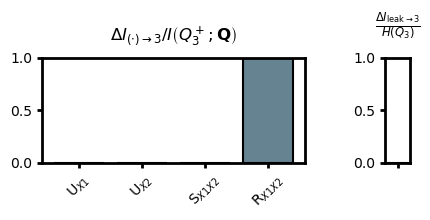

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9, 2.3), gridspec_kw={'width_ratios': [50, 1]})
plot_surd(a, axs=axs, threshold=0.0)
axs[0].set_title(f'${{\\Delta I}}_{{(\\cdot) \\rightarrow {3}}} / I \\left(Q_{3}^+ ; \\mathrm{{\\mathbf{{Q}}}} \\right)$', pad=12)
axs[1].set_title(f'$\\frac{{{{\\Delta I}}_{{\\mathrm{{leak}} \\rightarrow {3}}}}}{{H \\left(Q_{3} \\right)}}$', pad=20)
plt.tight_layout(w_pad=-13, h_pad=0)
plt.show()